# HEP analysis using Coffea + Work Queue Executor

In [1]:
# automatically reload python modules when they are modified
%load_ext autoreload
%autoreload 2



[Work Queue](https://cctools.readthedocs.io/en/stable/work_queue/) is a system and library for creating and managing scalable manager-worker style programs that scale up to thousands of machines on clusters, clouds, and grids. With Work Queue, Coffea sends the work to be done to a set of Work Queue workers. These workers may be running locally, remotely in a cluster, or in some container environment.

<img src="images/coffea-wq-general.png" title="Coffea Work Queue basic architecture" style="display:block; margin:auto;"/>

When used together with Coffea, it can measure the resources, such as cores and memory, that chunks of events need and adapt the allocations automatically to maximize throughput. In this notebook we will demonstrate how the executor can dynamically modify the size of chunks of events to process if the memory available is not enough, and adapt it to desired resources usage. But as a starter, let's first introduce its basic use for small local runs.

and how it can automatically
export the needed python environments when working in a cluster with no
previous setup.


## Load coffea

In [2]:
# all coffea applications are run by coffea.processor.Runner
from coffea.processor import Runner
from coffea.processor import WorkQueueExecutor

# workers will be created using this Factory
from work_queue import Factory

In [3]:
# test processor, modified from coffea source to make memory usage more interesting
#from MemNanoTestProcessor import MemNanoTestProcessor as MyProcessor

# or you can use the test processor included in coffea:

# Use a sample processor from coffea
# and silence coffea.hist deprecation, for now
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
from coffea.processor.test_items import NanoTestProcessor as MyProcessor

In [4]:
# Define example input file. 

filelist = {
    "ttHJet": ["http://www.crc.nd.edu/~kmohrman/files/root_files/for_ci/ttHJet_UL17_R1B14_NAOD-00000_10194.root"]
}

## Basic configure for the WorkQueue Executor

In [5]:
# For the most basic Work Queue configuration, we need to set the port that
# the workers will use to communicate with the Coffea application.
# The default for Work Queue is 9123, so we will use that here.
# We can set Work Queue to find a free port for use, and we will explore
# that later in the notebook.
port = 9123
executor = WorkQueueExecutor(port=port)
runner = Runner(executor)

#executor = WorkQueueExecutor(port=port, status_display_interval=5, extra_input_files=["MemNanoTestProcessor.py"])


## Running one function at a time

In Coffea, the iterative executor executes locally one function at a time. We can emulate this by directing the factory that creates workers to only create one worker. The factory automatically creates workers as it sees work available up to `max_workers`.

In [6]:
# Create a factory that looks for a running Coffea in the local machine at the
# port we defined above.
workers = Factory("local", manager_host_port = f"localhost:{port}")

# Tell the factory that it should not create more than one worker...
workers.max_workers = 1

# ...and that the worker should not use more than 10GB of memory. If we do not set
# resource limits, the worker automatically configures to use all available
# in the machine, so the worker will use, for example, all the cores and memory in the
# local machine.
workers.disk = 10000  # Each worker won't use more than 10GB

In [7]:
# Finally, we execute the Coffea application. By using the factory inside a 
# "with" statement, the factory shutdowns the workers when the workflow finishes.

with workers:
    hists = runner(filelist, "Events", MyProcessor())

GridspecLayout(children=(VBox(children=(HTML(value=''), HTML(value='')), layout=Layout(grid_area='widget001'))…

Listening for work queue workers on port 9123.


Preprocessing   0%|          | 0/1 [00:00<?, ?file/s]                               

Submitted       0%|          | 0/232632 [00:00<?, ?event/s]                         

Processing      0%|          | 0/232632 [00:00<?, ?event/s]                         

Accumulated     0%|          | 0/1 [00:00<?, ?task/s]                               

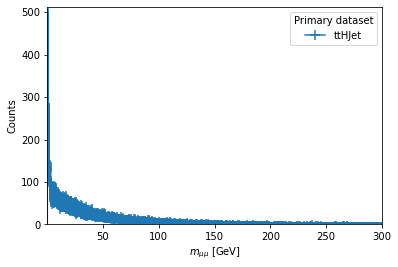

In [8]:
# we can plot the results as usual
%matplotlib inline
import coffea.hist
from IPython.utils import io
coffea.hist.plot1d(hists["mass"]);

## Manually declaring resources

As we saw above, each task (that is, each function) used at most 1 core, and only a small portion of the memory and disk available. Thus, if our worker has more than 1 core, it could run more than one task concurrently. This can be achieved by explicitely specifying how many resources a task should use. Note how Work Queue automatically allocates to the tasks a corresponding proportion for the resources that we did not specify, (i.e. memory and disk):

In [9]:
executor = WorkQueueExecutor(port=port, cores=1)
runner = Runner(executor)
with workers:
    hists = runner(filelist, "Events", MyProcessor())

GridspecLayout(children=(VBox(children=(HTML(value=''), HTML(value='')), layout=Layout(grid_area='widget001'))…

Listening for work queue workers on port 9123.


Submitted       0%|          | 0/232632 [00:00<?, ?event/s]                         

Processing      0%|          | 0/232632 [00:00<?, ?event/s]                         

Accumulated     0%|          | 0/1 [00:00<?, ?task/s]                               

## Automatic resource management

The previous example worked because we knew that each task did not use more than one core. Since we do not always know how many resouces a function will need, the Work Queue executor automatically adjust its allocations according to previous values measured. Preprocessing, processing, and accumulating tasks are handled separately

In fact, this is the default mode for the executor, only that we did not observe this in the previous examples because given the default coffea chunkise (100k events), there were not enough tasks for Work Queue to figure out an allocation. In the absence of data, Work Queue allocates a whole worker to a task. Thus, for the automatic resource management example, we set the chunksize to a small value to create tons of tasks. Later in this notebook we will show how Work Queue can also adap the chunksize to better use the resource allocations. 

In the output below, note how the `current allocation` of processing tasks eventually adapts to 1 core, even though there is no mention of cores when declaring the executor.

Not that the automatic resource management depends on measuring the resources used by coffea tasks, and this only works on Linux.

In [10]:
executor = WorkQueueExecutor(port=port)
runner = Runner(executor, chunksize=20000)
with workers:
    hists = runner(filelist, "Events", MyProcessor())


GridspecLayout(children=(VBox(children=(HTML(value=''), HTML(value='')), layout=Layout(grid_area='widget001'))…

Listening for work queue workers on port 9123.


Submitted       0%|          | 0/232632 [00:00<?, ?event/s]                         

Processing      0%|          | 0/232632 [00:00<?, ?event/s]                         

Accumulated     0%|          | 0/1 [00:00<?, ?task/s]                               

### Other resource management modes

#### Mixing explicitely declared resources and automatic modes

If resources are explicitely declared, such as `WorkQueueExecutor(..., cores=1, memory=4096, disk=8192)`, then Work Queue uses the values given as the maximum allocation a task can use. Otherwise, the maximum allocation is to use a whole worker.

#### Maximum throughput mode

The default resource management mode is to make new resource allocations using the maximum resources seen. This mode works nicely for most Coffea situations where processing functions use the same amount of cores. However, concurrenty may be greatly reduced if there are outliers than use more resources than the rest of the tasks. For such situations, the executor can be directed to use its maximum throughput setting, where Work Queue optimizes the number of tasks done per second, at the expense of retrying outliers using whole workers. For processing tasks that use about the same amount of resources, such as it is often seen in Coffea, both the default and the maximum throughput mode produce the same allocations.

```python
executor = WorkQueueExecutor(port=port, resources_mode="max-throughput")
```

Note that the maximum throughput mode, if active, only applies to processing tasks. Accumulating tasks always use the maximum seen allocations because they tend to grow in their resource usage as the run progresses.

#### Fixed mode

With the fixed mode, the executor does not adapt any of the allocations. If no resource is declared, then tasks use whole workers. Otherwise, undeclared resources are divided proportionally among the resources that were declared.

```python
executor = WorkQueueExecutor(port=port, resources_mode="fixed", cores=1, memory=4096, disk=8192)
```

If you want Work Queue to simply manage the resources, but not to enforce them, the resource monitor can be turned off:

```python
executor = WorkQueueExecutor(port=port, resources_mode="fixed", resource_monitor="off", cores=1, memory=4096, disk=8192)
```




## When task don't fit workers

#### Explicitely declared resources

If task resources are explicitely declared, but no connected worker is large enough to fit the task, then Work Queue will wait until a larger worker connects.

(In a notebook is hard to feed new workers, as execution blocks until a cell is completed. At the end of the notebook we present how to launch workers outside a notebook.)


#### Preprocessing and accumulating tasks that don't fit workers

If no explicit resources are declared, and the observed resources of preprocessing and accumulating tasks are larger than the currently connected workers, then Work Queu waits for larger workers to connect. Otherwise, if explicit resources were declared, the workflow fails.

Processing tasks are handled differently, as we present below dynamic chunksize strategies.

In [11]:
workers = Factory("local", manager_host_port = f"localhost:{port}")
workers.max_workers = 1
workers.memory = 4000
workers.disk = 10000

executor = WorkQueueExecutor(port=port, cores=1, memory=8000)
runner = Runner(executor)
with workers:
    hists = runner(filelist, "Events", MyProcessor())

GridspecLayout(children=(VBox(children=(HTML(value=''), HTML(value='')), layout=Layout(grid_area='widget001'))…

Listening for work queue workers on port 9123.


Submitted       0%|          | 0/232632 [00:00<?, ?event/s]                         

Processing      0%|          | 0/232632 [00:00<?, ?event/s]                         

Accumulated     0%|          | 0/1 [00:00<?, ?task/s]                               

## Adapting the number of events per processing task (i.e., the chunksize)

### Automatic splits

When a processing task exhausts its explicitely allocated resources, the set of events is divided and new processing tasks are created. This process is repeated as necessary, until the maximum number of retries is reach (default is 5), or when the chunksize can't be divided anymore.

In general, more than a handful of splits is indicative that the desired chunksize is too big, and it should be reduced for further runs.

In [12]:
# To test adapting the chunksize, we use a modified NanoTestProcessor.py,
# that artificially increases the memory used as a function of the number
# of events in the task.

from MemNanoTestProcessor import MemNanoTestProcessor as MyProcessor

In [13]:
# Also, since this processor is not part of coffea, we need to tell
# Work Queue to make it available at the workers. This is convenient,
# as we can quickly modify the processor without the need to re-install
# or re-build the coffea environments at the remote sites.

executor = WorkQueueExecutor(
    port=port,
    memory=1000,
    extra_input_files=["MemNanoTestProcessor.py"])

# set a large chunksize, to ensure that task fail
runner = Runner(executor, chunksize=256000) 

In [16]:
workers = Factory("local", manager_host_port = f"localhost:{port}")
workers.max_workers = 1
workers.memory = 2000
workers.disk = 10000

with workers:
    hists = runner(filelist, "Events", MyProcessor())

GridspecLayout(children=(VBox(children=(HTML(value=''), HTML(value='')), layout=Layout(grid_area='widget001'))…

Listening for work queue workers on port 9123.


Submitted       0%|          | 0/232632 [00:00<?, ?event/s]                         

Processing      0%|          | 0/232632 [00:00<?, ?event/s]                         

Accumulated     0%|          | 0/1 [00:00<?, ?task/s]                               

processing task id 1 item p_31 with 232632 events completed on cclws16.cse.nd.edu. return code 143
task id 1 item p_31 failed: RESOURCE_EXHAUSTION
    ('ttHJet', 'http://www.crc.nd.edu/~kmohrman/files/root_files/for_ci/ttHJet_UL17_R1B14_NAOD-00000_10194.root', 'Events', 0, 232632) p_31 without result.


IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


processing task id 2 item p_32 with 116316 events completed on cclws16.cse.nd.edu. return code 143
task id 2 item p_32 failed: RESOURCE_EXHAUSTION
    ('ttHJet', 'http://www.crc.nd.edu/~kmohrman/files/root_files/for_ci/ttHJet_UL17_R1B14_NAOD-00000_10194.root', 'Events', 0, 116316) p_32 without result.
processing task id 3 item p_33 with 116316 events completed on cclws16.cse.nd.edu. return code 143
task id 3 item p_33 failed: RESOURCE_EXHAUSTION
    ('ttHJet', 'http://www.crc.nd.edu/~kmohrman/files/root_files/for_ci/ttHJet_UL17_R1B14_NAOD-00000_10194.root', 'Events', 116316, 232632) p_33 without result.


## Dynamic chunksize computation

The Work Queue executor can also modify the chunksize to a desired memory target usage. In the following example we start with a small chunksize, which grows to fill the desired allocations.

In [ ]:
target_memory = 1000  # 1GB

executor = WorkQueueExecutor(
    port=port,
    extra_input_files=["MemNanoTestProcessor.py"],
    memory=target_memory)                        # do not use more than the target memory

# set a small chunksize, to create tons of tasks from the single example file.
runner = Runner(
    executor, 
    chunksize=1000,
    dynamic_chunksize={"memory": target_memory})

workers = Factory("local", manager_host_port = f"localhost:{port}")
workers.max_workers = 1
workers.memory = 2000
workers.disk = 10000

with workers:
    hists = runner(filelist, "Events", MyProcessor())

GridspecLayout(children=(VBox(children=(HTML(value=''), HTML(value='')), layout=Layout(grid_area='widget001'))…

Listening for work queue workers on port 9123.


Submitted       0%|          | 0/232632 [00:00<?, ?event/s]                         

Processing      0%|          | 0/232632 [00:00<?, ?event/s]                         

Accumulated     0%|          | 0/10 [00:00<?, ?task/s]                              

## Using remote workers

### Catalog server

### Create an environment

### The factory outside a notebook